# Header

Imports

In [60]:
import os

# Data Processing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# SentencePiece
import sentencepiece as spm

# Word2Vec
from gensim.models import Word2Vec
from gensim.models import FastText

# Model Evaluation
from sklearn.model_selection import train_test_split

# Model Creation
import torch
import torch.nn as nn
import torch.optim as optim

Preprocessing Data Functions

In [61]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence
        
def get_sentence_tokens(sentence, sp):
    '''Gets the word tokens of a given sentence by tokenising'''
    tokens = sp.encode_as_pieces(sentence)
    return tokens

def get_avg_vector_for_sent(tokens, model):
    '''Uses the Word2Vec LUT to get the vector representation of a tokens 
       in a sentence and takes the mean'''
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector
    
def sentence_to_vector(sentence, model,sp):
    '''Returns the vector representation of a sentence
       by taking the average of the Word2Vec representations of the 
       words / subwords'''
    tokens = get_sentence_tokens(sentence,sp)
    vector = get_avg_vector_for_sent(tokens, model)
    return vector

def train_fasttext_model(tokenized_texts, vector_size=25):
    fasttext_model = FastText(sentences=tokenized_texts, vector_size=vector_size, window=5, min_count=1, workers=4, sg=1)  # sg=1 means skip-gram
    return fasttext_model

def fasttext_sentence_to_vector(sentence, model):
    '''Directly uses FastText to get the vector representation of a sentence'''
    # Splitting the sentence into words; this could be replaced or refined as needed
    tokens = sentence.split()  
    vector = np.zeros(model.vector_size)
    for token in tokens:
        vector += model.wv[token]  # FastText will handle OOV words using n-grams
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector


Preprocessing to Model Functions

Model Creation

In [62]:
class UpvotesPredictorNN(nn.Module):
    def __init__(self, word_dimensionality):
        super(UpvotesPredictorNN, self).__init__()
        
        # Input layer to 1st hidden layer
        self.fc1 = nn.Linear(word_dimensionality, 128)
        self.relu1 = nn.ReLU()
        
        # 1st hidden layer to 2nd hidden layer
        self.fc2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        
        # 2nd hidden layer to output layer
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.output(x)
        return output

# Main Execution

Set Env

In [63]:
if os.sys.platform == 'darwin':      # MacOS
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif os.sys.platform == 'win32':    # Windows
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:                               # other OS
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


Load Dataset

In [64]:
file_path = './data/TitlesAndScoreALL.csv'
data_df = pd.read_csv(file_path, sep=',')

Set Embedding Dim

In [65]:
word_dimensionality = 25

Generate Embeddings

In [66]:
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(data_df['title']), 
    vocab_size=12_828,
    model_prefix='./data/spm_model', 
    model_type='word',
)
sp = spm.SentencePieceProcessor()
sp.load('./data/spm_model.model')

tokenized_titles = [sp.encode_as_pieces(title) for title in data_df['title']]

# word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=word_dimensionality, window=5, min_count=1, workers=4, sg=1)
# data_df['sentence_vector'] = data_df['title'].apply(lambda x: sentence_to_vector(x, word2vec_model, sp))

fasttext_model = FastText(sentences=data_df['title'], vector_size=word_dimensionality, window=5, min_count=1, workers=4, sg=1)
data_df['sentence_vector'] = data_df['title'].apply(lambda x: fasttext_sentence_to_vector(x, fasttext_model))


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: ./data/spm_model
  model_type: WORD
  vocab_size: 12828
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential

Train Test Split

In [67]:
# Split the data into training and test sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    data_df['sentence_vector'].tolist(), 
    data_df['score'], 
    test_size=0.3, 
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)

X_train = torch.tensor(np.vstack(X_train), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1).to(device)

X_val = torch.tensor(np.vstack(X_val), dtype=torch.float32).to(device)
y_val = torch.tensor(np.array(y_val), dtype=torch.float32).view(-1, 1).to(device)

X_test = torch.tensor(np.vstack(X_test), dtype=torch.float32).to(device)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1).to(device)

Training Loop

In [68]:
# Define model and hyperparameters
model = UpvotesPredictorNN(word_dimensionality=word_dimensionality).to(device)
criterion = nn.MSELoss()
num_epochs = 2000
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Storage object for data vis
list_of_lists = []

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    
    
    # Set model to evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(X_test.to(device))
        val_loss = criterion(predictions, y_test.to(device))
    
    # Store loss for data vis
    list_of_lists.append([epoch, loss.item(), val_loss.item()])
    
    # # Logging
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1},\t Train Loss: {loss.item()},\t Val Loss: {val_loss.item()}')

Epoch 1,	 Train Loss: 321.7630615234375,	 Val Loss: 293.90582275390625
Epoch 101,	 Train Loss: 272.9645690917969,	 Val Loss: 247.18722534179688
Epoch 201,	 Train Loss: 267.0618896484375,	 Val Loss: 242.920166015625
Epoch 301,	 Train Loss: 266.6505126953125,	 Val Loss: 242.5613250732422
Epoch 401,	 Train Loss: 266.4088439941406,	 Val Loss: 242.37669372558594
Epoch 501,	 Train Loss: 266.2508239746094,	 Val Loss: 242.26885986328125
Epoch 601,	 Train Loss: 266.1244812011719,	 Val Loss: 242.18914794921875
Epoch 701,	 Train Loss: 266.0177307128906,	 Val Loss: 242.12942504882812
Epoch 801,	 Train Loss: 265.93170166015625,	 Val Loss: 242.09165954589844
Epoch 901,	 Train Loss: 265.8650207519531,	 Val Loss: 242.07164001464844
Epoch 1001,	 Train Loss: 265.81451416015625,	 Val Loss: 242.05853271484375
Epoch 1101,	 Train Loss: 265.76837158203125,	 Val Loss: 242.04295349121094
Epoch 1201,	 Train Loss: 265.69586181640625,	 Val Loss: 242.0098876953125
Epoch 1301,	 Train Loss: 265.6026611328125,	 Val L

Evaluation

In [69]:
train_loss_list = []
val_loss_list = []
epoch_list = []

for i,j,k in list_of_lists:
    epoch_list.append(i)
    train_loss_list.append(j)
    val_loss_list.append(k)

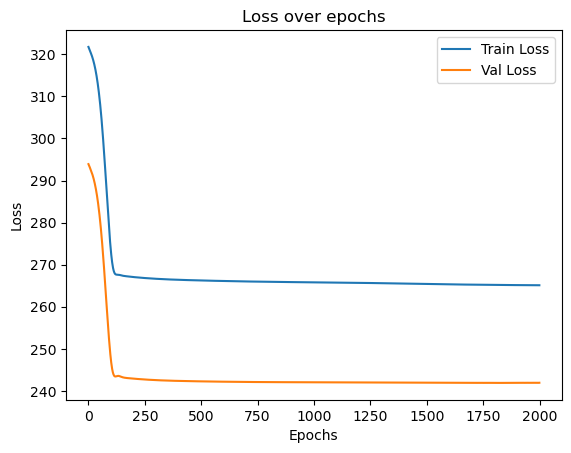

In [70]:
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test) 

print(f'Test Loss: {test_loss.item()}')

Test Loss: 241.9383544921875
